# Inner Visualizer Process

---

## 1. Set API Keys

In [33]:
import os

# Load API Keys
from config.secret_keys import OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## 2. Import Modules

In [34]:
# directory setting
from pathlib import Path

# Define State
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# Define Tools
import pandas as pd
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Define Nodes
from langchain_core.messages import HumanMessage, AIMessage

# Define Agent
from langgraph.prebuilt import create_react_agent
from datetime import datetime

# Build Graph
from langgraph.graph import START, END, StateGraph

## 3. Directory Setting

In [35]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data' # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / 'charts' # 차트 저장용 디엑토리

## 4. Build Application

### 4-1. Define State

In [36]:
class State(TypedDict):
    # messages: Annotated[list, operator.add]
    messages : Annotated[List[BaseMessage], add_messages]

### 4-2. Define Tools

In [46]:
# python code interpreter
repl = PythonREPL()

@tool
def analyze_data(query : str):
    """
    저장된 데이터를 pandas_agent로 분석하고 분석한 내용을 시각화 합니다.
    """

    data_path = DATA_DIR / "stock_data.csv"
    data = pd.read_csv(data_path)

    custom_prefix = f"""
        You are very smart analyst with datafram.

        Please analyze the data in various perspective to fine valuable insight.

        You shoould always make the greatest output with accurate metrics and graph.

        data path : {data_path}
    """

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [data],
        verbose=True,
        # verbose=False,
        agent_type = AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix
    )

    result = pandas_agent.invoke(query)

    return result

@tool
def chart_generator(query:str):
    """
    이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다.
    """

    data = pd.read_csv(DATA_DIR / "stock_data.csv")
    custom_prefix = """
        Please make the chart and save in './charts' folder.
        data path is './data/stock_data.csv'
    """

    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [data],
        verbose=True,
        # verbose=False,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix
    )

    result = agent.invoke(query)

    return result

### 4-3. Define Agent

In [47]:
today = datetime.today().date().strftime('%Y-%m-%d')

analyst_prompt = f"""
오늘은 {today}입니다. 

당신은 뛰어난 데이터 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 주어진 데이터에 대해 사용자가 원하는 형태의 시각화 하여 /chart 폴더에 저장하는 것.
2. 주어진 데이터에 대해 사용자가 원하는 시각 뿐만 아닌 다양한 시각으로 분석하고 이에 대한 인사이트를 발견하는 것.
3. 발견한 Insight에 대해 시각화 하여 /chart 폴더에 저장하는 것.

당신의 추론을 항상 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.

분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요."""

In [48]:
llm = ChatOpenAI(
    model="gpt-4o-mini"
)

analyst_agent = create_react_agent(
    llm, 
    [analyze_data, chart_generator], 
    state_modifier = analyst_prompt
)

### 4-4. Define Node

In [49]:
def inner_visualizer_node(state : dict):
    messages = state["messages"]

    # result = analyst_agent.invoke(
    #     {"messages" : [
    #             {
    #                 'role' : 'human',
    #                 'content' : f"""
    #                     Analyze Given Data and Visualize Chart, 
                    
    #                     User Message : {messages[0]['content']}
    #                 """
    #             }
    #         ]
    #     }
    # )

    result = analyst_agent.invoke(
        {"messages" : [
            HumanMessage(
                content = f"""
                    Analyze given data and Visualize Chart,

                    Human Message : {messages[0].content}
                """
            )
        ]}
    )

    return result

### 4-3. Build Graph

In [50]:
workflow = StateGraph(State)

workflow.add_node("inner_visualizer", inner_visualizer_node)

workflow.add_edge(START, "inner_visualizer")
workflow.add_edge("inner_visualizer", END)

app = workflow.compile()

### 4-4. Visualize Graph

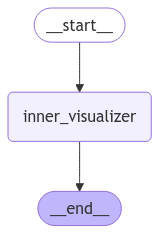

In [51]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## 5. Test Application



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\n\n# Load the data\ndf = pd.read_csv('c:/SKN05-FINAL-3TEAM/model/data/stock_data.csv')\n\n# Convert 'Date' to datetime object\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Define the periods\ndf['Period'] = 'Non-Covid'\ndf.loc[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-12-31'), 'Period'] = 'Covid'\n\n# Calculate the mean returns and standard deviation for each period, excluding Nasdaq\nstock_columns = df.columns.difference(['Date', 'Nasdaq', 'Period'])\n\n# Calculate returns first\ndf[stock_columns] = df[stock_columns].pct_change()\n\n# Group by period and calculate mean and std dev\nmean_returns = df.groupby('Period')[stock_columns].mean()\nvolatility = df.groupby('Period')[stock_columns].std()\n\nmean_returns, volatility"}`


(               AAPL      AMZN         F        GM      GOOG     GOOGL  \
Period                                                                  


<Figure size 1200x800 with 0 Axes>


Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\n# Save the standard deviation data\nstd_data = pd.DataFrame({'Non-Corona': std_non_corona, 'Corona': std_corona})\n\n# Plot the data\nplt.figure(figsize=(12, 8))\nstd_data.plot(kind='bar')\nplt.title('Stock Volatility (Standard Deviation) During Non-Corona vs Corona Periods')\nplt.ylabel('Standard Deviation')\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n# Save the plot\nos.makedirs('./charts', exist_ok=True)\nplt.savefig('./charts/stock_volatility_comparison.png')\nplt.show()"}`




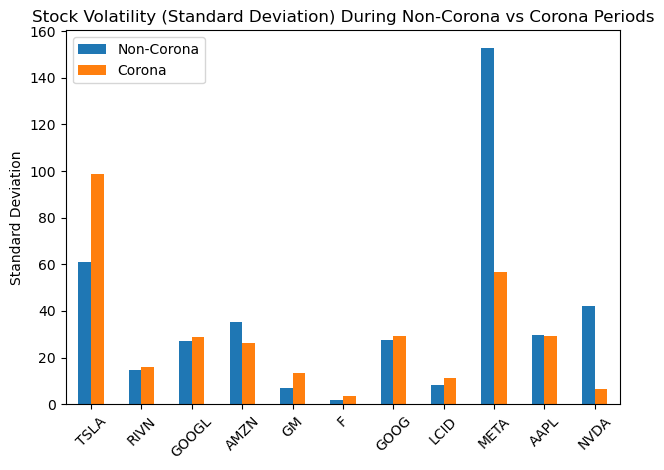


Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\n# Drop Nasdaq from the results\ndel average_returns_covid['Nasdaq']\ndel average_returns_non_covid['Nasdaq']\n\n# Create a DataFrame for easy plotting\naverage_returns = pd.DataFrame({\n    'COVID Period (2020-2021)': average_returns_covid,\n    'Non-COVID Period (2019, 2022+)': average_returns_non_covid\n})\n\n# Plot the average returns\nplt.figure(figsize=(10, 6))\naverage_returns.plot(kind='bar')\nplt.title('Average Stock Returns during COVID vs Non-COVID Periods')\nplt.xlabel('Stocks')\nplt.ylabel('Average Daily Returns')\nplt.xticks(rotation=45)\nplt.grid(axis='y')\nplt.tight_layout()\nplt.savefig('./charts/average_stock_returns_covid_vs_noncovid.png')\nplt.show()"}`




<Figure size 1000x600 with 0 Axes>

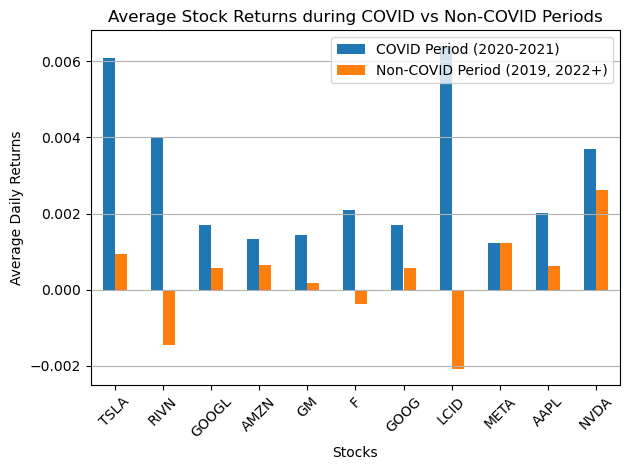

주가 데이터에서 NASDAQ을 제외하고 코로나 시기(2020년 1월 ~ 2021년 12월)와 비코로나 시기(2019년 및 2022년 이후)의 변동성(표준편차)을 시각화한 차트를 생성하였습니다. 차트는 `./charts/stock_volatility_comparison.png`에 저장되었습니다.

> Finished chain.
코로나 시기(2020년 1월 ~ 2021년 12월)와 비코로나 시기(2019년 및 2022년 이후)의 평균 주식 수익률을 비교한 막대 차트를 생성하고 './charts/average_stock_returns_covid_vs_noncovid.png'에 저장했습니다.

> Finished chain.
Receving update from node: 'inner_visualizer
{'messages': [HumanMessage(content='\n                    Analyze given data and Visualize Chart,\n\n                    Human Message : 주어진 주가 데이터에서 NASDAQ을 제외하고 코로나 시기와 아닌 시기의 차이를 분석할 수 있도록 분석 및 시각화 해줘\n                ', additional_kwargs={}, response_metadata={}, id='c87dde3a-ef0b-42c7-9a19-dc397d887be6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gWFldB7vhmonUluNQhyvZnrO', 'function': {'arguments': '{"query":"주가 데이터에서 NASDAQ을 제외하고 코로나 시기(2020년 1월 ~ 2021년 12월)와 비코로나 시기(2019년 및 2022년 이후)로 나누어 각각의 평균 수익률, 변동성(표준편차), 그리고 거래량을 비교해 주세요."}', 'name': 'analyze_data'}, 'type'

In [56]:
config = {"recursion_limit" : 30}
inputs = {'messages' : [
        {
            'role' : 'human',
            'content' : '주어진 주가 데이터에서 NASDAQ을 제외하고 코로나 시기와 아닌 시기의 차이를 분석할 수 있도록 분석 및 시각화 해줘'
        }
    ]
}

for chunk in app.stream(inputs, config, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")